# 1.Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.

##Download data and model

In [ ]:
#setting the data
import tensorflow as tf
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-02 01:59:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   125MB/s    in 10s     

2023-02-02 01:59:41 (152 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir ="101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
#Load in saved model
model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model on test data
food_model = model.evaluate(test_data)
food_model

790/790 [==============================] - 66s 72ms/step - loss: 1.7995 - accuracy: 0.6181


[1.7994718551635742, 0.61809903383255]

## Load and prep image 

In [ ]:
def load_and_prep_image(filename,img_shape=224,scale = True):
  #Read in the image
  img = tf.io.read_file(filename)

  #decode image to tensor
  img = tf.io.decode_image(img,channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  #scale? yes/no
  if scale:
    return img/255. 
  else:
    return img

In [ ]:
#get list of class names
class_names = test_data.class_names

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Load image and predict

In [ ]:
zip_ref = zipfile.ZipFile("/content/sample_data/Predict.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
filepred = '/content/Predict'

In [ ]:
import os
pred_im=os.listdir(filepred)

In [ ]:
pred_im = pred_im[0:3]

In [ ]:
pred_im

['lasagna.jpeg', 'ice cream.jpeg', 'fried-rice.jpeg']

1/1 [==============================] - 0s 29ms/step


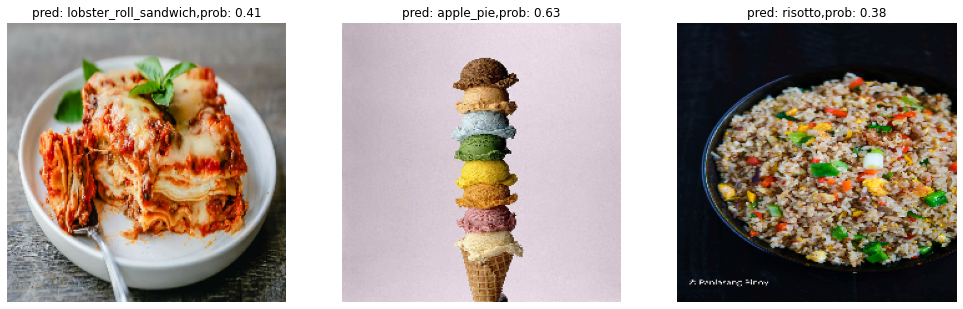

In [ ]:
from tensorflow.python.ops.gen_math_ops import arg_max
#make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17,10))
j=0
for i in pred_im:
  
  filepath = filepred +"/" + i

  #load image and make predictions
  img = load_and_prep_image(filepath,scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #print(pred_prob)
  #print(pred_class)

  #Plot images
  plt.subplot(1,3,j+1)
  plt.imshow(img/255.)
  j+=1
  # if class_name == pred_class:
  #   title_color = "g"
  # else:
  #   title_color ="r"
  plt.title(f"pred: {pred_class},prob: {pred_prob.max():.2f}")
  plt.axis(False);

#2.Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?


In [ ]:
#Create checpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
#Create data augmentation layer to incoporate right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescale(1/255.) required for ResNet models
], name = "data_augmentation")

In [ ]:
#setup the base model and freee its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name ="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training= False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Compile
model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#Fit
history_all_classes_10_percent= model.fit(train_data_all_10_percent,
                                          epochs=10,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 *len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/10
237/237 [==============================] - 56s 212ms/step - loss: 1.3606 - accuracy: 0.6605 - val_loss: 1.7055 - val_accuracy: 0.5540
Epoch 2/10
237/237 [==============================] - 48s 200ms/step - loss: 1.2221 - accuracy: 0.6929 - val_loss: 1.6732 - val_accuracy: 0.5577
Epoch 3/10
237/237 [==============================] - 47s 196ms/step - loss: 1.1298 - accuracy: 0.7203 - val_loss: 1.6985 - val_accuracy: 0.5548
Epoch 4/10
237/237 [==============================] - 46s 192ms/step - loss: 1.0645 - accuracy: 0.7362 - val_loss: 1.6416 - val_accuracy: 0.5625
Epoch 5/10
237/237 [==============================] - 43s 182ms/step - loss: 1.0010 - accuracy: 0.7453 - val_loss: 1.6810 - val_accuracy: 0.5540
Epoch 6/10
237/237 [==============================] - 43s 180ms/step - loss: 0.9409 - accuracy: 0.7732 - val_loss: 1.6800 - val_accuracy: 0.5535
Epoch 7/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8888 - accuracy: 0.7827 - val_loss: 1.6037 - val_ac

In [ ]:
 model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.5249 - accuracy: 0.5945


[1.5248697996139526, 0.5944554209709167]

#3.Recreate the first model (the feature extraction model) with mixed_precision turned on.

In [ ]:
#turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.4/394.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 KB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.5 MB/s eta 0:00:00
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4849 sha256=10279c2cb9af8ba21d743ff3e1993cb28114864268f0a5e8afe30a42d4383ad3
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.wh

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create base model
input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create functional model
inputs = layers.Input(shape = input_shape, name="input_layer")
#x = preprocessing.Rescaling(1./255) for models wit no scaling
x = base_model(inputs,training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32, name ="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

#compile model
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
!wget https://raw.githubusercontent.com/krishnamenon215/Tensorflow/main/helper_functions.py
#Import series of helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-02-02 02:05:51--  https://raw.githubusercontent.com/krishnamenon215/Tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-02 02:05:51 (65.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
checkpoint_path ="model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data_all_10_percent,
                                                     epochs =3,
                                                     steps_per_epoch=len(train_data_all_10_percent),
                                                     validation_data= test_data,
                                                     validation_steps = int(0.5 * len(test_data)),
                                                     callbacks =[create_tensorboard_callback(dir_name="training_logs",
                                                                                             experiment_name="efficientnetb0_101_classes_10_feature_extract"),
                                                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_10_feature_extract/20230202-020922
Epoch 1/3
  9/237 [>.............................] - ETA: 8:58:29 - loss: nan - accuracy: 0.0069